# Pytorch optimizer - gradient direction tuning via learning rate

In [1]:
!pip install torch_optimizer
import torch_optimizer as optim
import torch
import math
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
# !pip install hyperopt
from hyperopt import fmin, hp, tpe
# !pip install --upgrade numpy
import torch_optimizer as optim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [5]:
# @title Optimizer Visualization


plt.style.use("seaborn-white")


def rosenbrock(tensor):
    x, y = tensor
    return (1 - x) ** 2 + 100 * (y - x**2) ** 2



def execute_steps(
    func, initial_state, optimizer_class, optimizer_config, num_iter=500
):
    x = torch.Tensor(initial_state).requires_grad_(True)
    optimizer = optimizer_class([x], **optimizer_config)
    steps = []
    steps = np.zeros((2, num_iter + 1))
    steps[:, 0] = np.array(initial_state)
    for i in range(1, num_iter + 1):
        optimizer.zero_grad()
        f = func(x)
        f.backward(create_graph=True, retain_graph=True)
        torch.nn.utils.clip_grad_norm_(x, 1.0)
        optimizer.step()
        steps[:, i] = x.detach().numpy()
    return steps


def objective_rosenbrok(params):
    lr = params["lr"]
    optimizer_class = params["optimizer_class"]
    minimum = (1.0, 1.0)
    initial_state = (-2.0, 2.0)
    optimizer_config = dict(lr=lr)
    num_iter = 100
    steps = execute_steps(
        rosenbrock, initial_state, optimizer_class, optimizer_config, num_iter
    )
    return (steps[0][-1] - minimum[0]) ** 2 + (steps[1][-1] - minimum[1]) ** 2



def plot_rosenbrok(grad_iter, optimizer_name, lr):
    x = np.linspace(-2, 2, 250)
    y = np.linspace(-1, 3, 250)
    minimum = (1.0, 1.0)

    X, Y = np.meshgrid(x, y)
    Z = rosenbrock([X, Y])

    iter_x, iter_y = grad_iter[0, :], grad_iter[1, :]

    fig = plt.figure(figsize=(8, 8))

    ax = fig.add_subplot(1, 1, 1)
    ax.contour(X, Y, Z, 90, cmap="jet")
    ax.plot(iter_x, iter_y, color="r", marker="x")

    ax.set_title(
        "Rosenbrock func: {} with {} "
        "iterations, lr={:.6}".format(optimizer_name, len(iter_x), lr)
    )
    plt.plot(*minimum, "gD")
    plt.plot(iter_x[-1], iter_y[-1], "rD")
    if not os.path.exists("./docs/"):
        os.mkdir("./docs/")
    plt.savefig("docs/rosenbrock_{}.png".format(optimizer_name))


def execute_experiments(
    optimizers, objective, func, plot_func, initial_state, seed=1
):
    seed = seed
    for item in optimizers:
        optimizer_class, lr_hi = item
        lr_low = -8.0
        space = {
            "optimizer_class": hp.choice("optimizer_class", [optimizer_class]),
            "lr": hp.loguniform("lr", lr_low, lr_hi),
        }
        best = fmin(
            fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=200,
            rstate=np.random.default_rng(seed),
        )
        print(best["lr"], optimizer_class)

        steps = execute_steps(
            func,
            initial_state,
            optimizer_class,
            {"lr": best["lr"]},
            num_iter=500,
        )
        plot_func(steps, optimizer_class.__name__, best["lr"])


def LookaheadYogi(*a, **kw):
    base = optim.Yogi(*a, **kw)
    return optim.Lookahead(base)


if __name__ == "__main__":
    # Each optimizer has tweaked search space to produce better plots and
    # help to converge on better lr faster.
    optimizers = [
        (torch.optim.SGD, -1.0),  # default example (high_lr = 10^-1.0) got the best lr at 0.367397
        (optim.SGDW, -1.0),   #<---- lr high range adjustment by urself
        (torch.optim.Adagrad, -1.0),  #<---- lr high range adjustment by urself
        (torch.optim.Adam, -1.0), #<---- lr high range adjustment by urself
      ]

    # plotting on rosenbrock space
    execute_experiments(
        optimizers,
        objective_rosenbrok,
        rosenbrock,
        plot_rosenbrok,
        (-2.0, 2.0),  #<--- Default seed
    )

Output hidden; open in https://colab.research.google.com to view.

----------
# Exam


5. (ไฟล์ Exam5_Gradient_Plot_RosenBrock_Space.ipynb) กำหนดให้ฟังก์ชั่นพื้นที่ Rosenbrock Banana (ตามรูปข้างใต้ข้อ 5) เป็นฟังก์ชันไม่นูน (non-convex function) ที่มีค่าต่ำสุดสากล (global minimum) หนึ่งค่าที่ (1.0. 1.0) ค่าต่ำสุดสากลอยู่ภายในหุบเขาแบนยาวแคบรูปพาราโบลา จงปรับค่าอัตราการเรียนรู้เองที่ดีที่สุดที่ใช้ในฟังก์ชั่นการค้นหา hyperparameter อัตโนมัติ (hp.loguniform) สำหรับการใช้ Optimizer แบบ SGD with Momentum & Weight Decay (SGDW), Adaptive Gradient (Adagrad), และ Adaptive Gradient with Momentum (Adam) เปรียบเทียบและอธิปรายผล learning rate ที่ดีที่สุดที่ได้ จากทุก Optimizer และทุก Gradient ที่วิ่งใน RosenBrock space จัดทำเป็น PDF
กำหนดให้ Seed เริ่มต้นสำหรับ Rosenbrock คือ (-2.0, 2.0), จำนวนรอบวนซ้ำ (num_iter) เท่ากันที่ 500 รอบ สำหรับ Optimizer ทดสอบ และ learning rate ของ SGD ตัวอย่างอยู่ที่ high_lr = -1.0 (10^-1 หรือ 0.1)

ตัวอย่าง Rosenbrock banana space function\
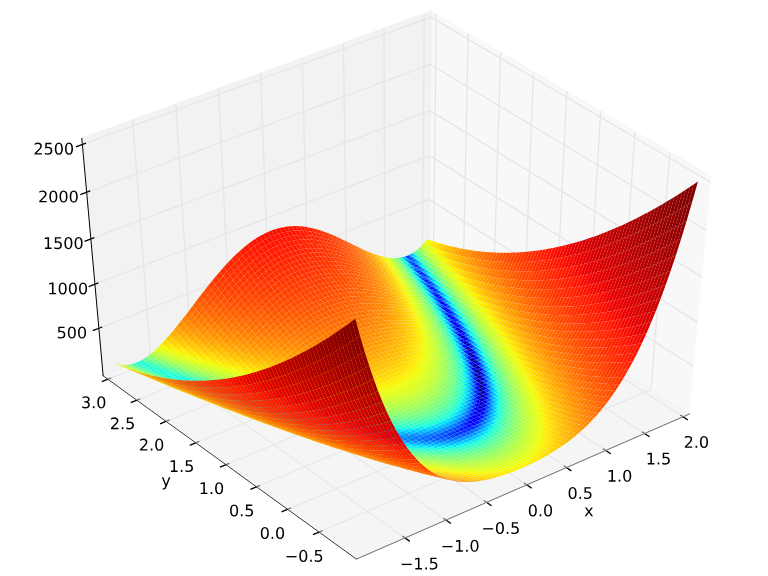


ตัวอย่าง Gradient ของ SGD ใน Rosenbrock space ได้ค่าที่ดีที่สุดที่ lr = 0.367397 จากการค้นหาอัตโนมัติ\
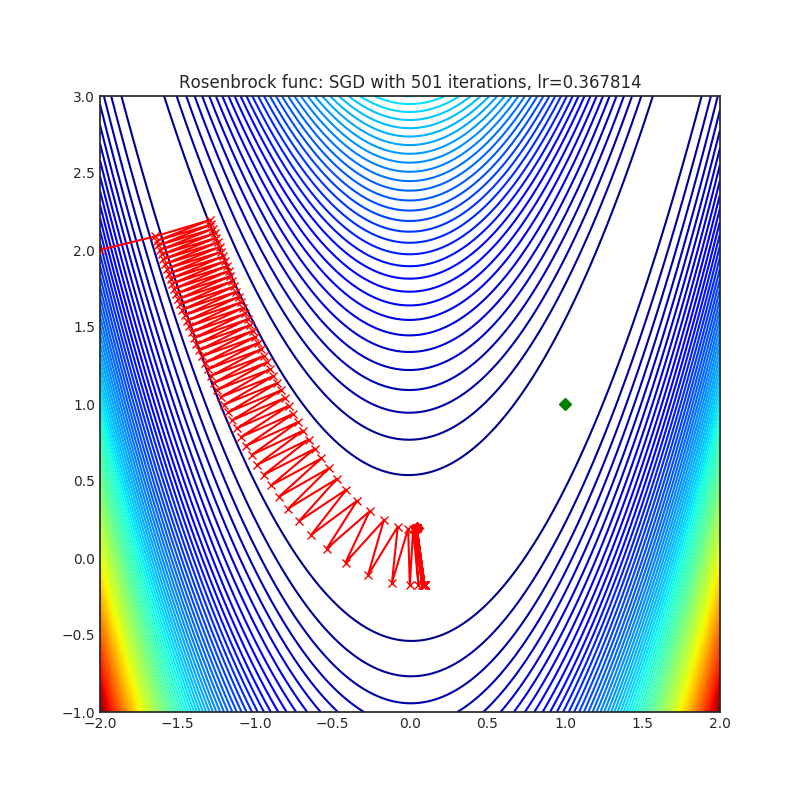